# Experiments

## Imports

In [1]:
import jax 
import jax.numpy as jnp
import optax 
from jax import config 
config.update("jax_enable_x64", True)

import backward_ica.hmm as hmm
import backward_ica.utils as utils
from backward_ica.svi import SVITrainer

## Common setup

In [2]:
seed_model_params = 1326 # one seed for the true model
seed_infer = 4569 # one seed for the approximating models 

num_fits = 5 # number of starting points for the optimisation of variational models
state_dim, obs_dim = 1,1 
seq_length = 64 # length of each training sequence
num_seqs = 2048 # number of sequences in the training set

batch_size = 64 # here a batch is a group of sequences 
learning_rate = 1e-2 
num_epochs = 150 
num_batches_per_epoch = num_seqs // batch_size
optimizer = optax.adam(learning_rate=learning_rate)
num_samples = 3 # number of samples for the monte carlo approximation of the expectation of the (possibly nonlinear) emission term

## Linear case

In [3]:
key = jax.random.PRNGKey(seed_model_params)
infer_key = jax.random.PRNGKey(seed_infer)

### Define true model, get samples and compute reference likelihood via Kalman

In [4]:
p = hmm.LinearGaussianHMM(state_dim=state_dim, 
                        obs_dim=obs_dim, 
                        transition_matrix_conditionning='diagonal') # specify the structure of the true model
key, subkey = jax.random.split(key, 2)
p_params = p.get_random_params(subkey) # sample params randomly (but covariances are fixed to default values)

key, subkey = jax.random.split(key, 2)
state_seqs, obs_seqs = hmm.sample_multiple_sequences(subkey, p.sample_seq, p_params, num_seqs, seq_length)

evidence_seq = jax.vmap(lambda obs_seq: p.likelihood_seq(obs_seq, p_params))(obs_seqs)
avg_evidence_kalman = jnp.mean(evidence_seq)
print('Avg evidence given by Kalman:', avg_evidence_kalman)

Avg evidence given by Kalman: 97.5256000612925


### Define and fit the variational model

End of fit 1/5, final ELBO 95.561
End of fit 2/5, final ELBO 97.294
End of fit 3/5, final ELBO 95.248
End of fit 4/5, final ELBO 96.517
End of fit 5/5, final ELBO 96.197
Best fit is 2
Kalman MSE averaged across all sequences: 0.0003622034408026094
Backward variational MSE averaged across all sequences: 0.0003647868697525651


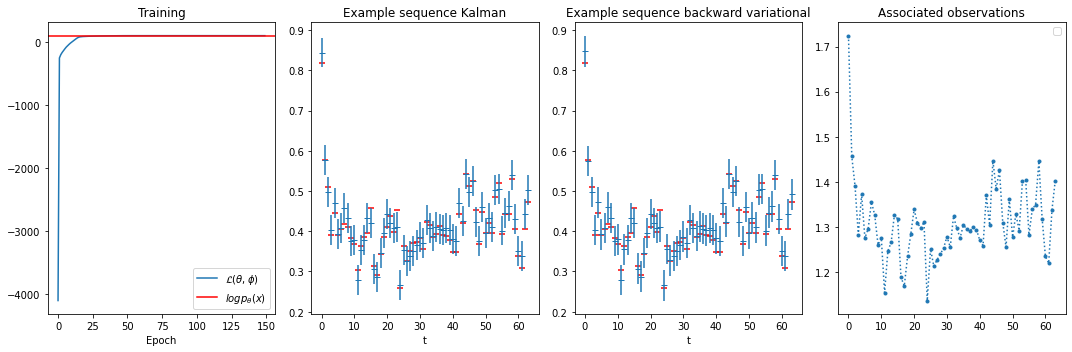

In [5]:
q = hmm.LinearGaussianHMM(state_dim=state_dim, 
                        obs_dim=obs_dim, 
                        transition_matrix_conditionning='diagonal') # specify the structure of the true model, but init params are sampled during optimisiation     

trainer = SVITrainer(p, q, optimizer, num_epochs, batch_size, num_samples)

q_params, avg_elbos = trainer.multi_fit(obs_seqs, p_params, infer_key, num_fits=num_fits) # returns the best fit (based on the last value of the elbo)
utils.plot_fit_results_1D_against_reference(p, q, p_params, q_params, state_seqs, obs_seqs, avg_elbos, avg_evidence_kalman)

### Evaluate smoothing performance w.r.t sequence length

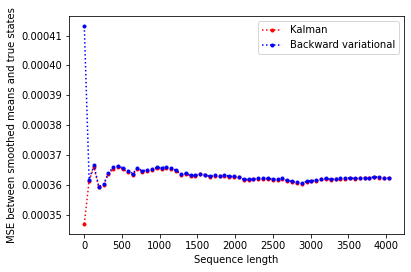

In [6]:
num_test_seqs = 32
test_seqs_length = 4096
test_state_seqs, test_obs_seqs = hmm.sample_multiple_sequences(key, p.sample_seq, p_params, num_test_seqs, test_seqs_length) # sample longer sequences

utils.compare_mse_for_different_lengths_against_reference(p, q, p_params, q_params, test_state_seqs, test_obs_seqs, step=64) # we compute smoothing with increasingly long sequences

## Nonlinear case

In [7]:
# we get the same random keys therefore the transition kernel is identical to the one in the linear case
key = jax.random.PRNGKey(seed_model_params)
infer_key = jax.random.PRNGKey(seed_infer)
num_particles = 1000 # number of particles for the smc runs

### Define true model, get samples, and compute reference likelihood via bootstrap SMC

In [8]:
p = hmm.NonLinearGaussianHMM(state_dim=state_dim, 
                        obs_dim=obs_dim, 
                        transition_matrix_conditionning='diagonal') # the emission map is a fully connected neural network with 8 neurons in the hidden layer

key, subkey = jax.random.split(key, 2)
p_params = p.get_random_params(subkey)

key, subkey = jax.random.split(key, 2)
state_seqs, obs_seqs = hmm.sample_multiple_sequences(subkey, p.sample_seq, p_params, num_seqs, seq_length)

smc_likel = lambda obs_seq, prior_keys, resampling_keys, proposal_keys: p.likelihood_seq(obs_seq,
                                                                                    prior_keys, 
                                                                                    resampling_keys, 
                                                                                    proposal_keys, 
                                                                                    p_params,
                                                                                    num_particles)

prior_key, resampling_key, proposal_key = jax.random.split(key, 3)
prior_keys = jax.random.split(prior_key, num_seqs * num_particles).reshape(num_seqs, num_particles, -1)
resampling_keys = jax.random.split(resampling_key, num_seqs * (seq_length - 1)).reshape(num_seqs, seq_length - 1, -1)
proposal_keys = jax.random.split(proposal_key, num_seqs * (seq_length - 1)).reshape(num_seqs, seq_length - 1, -1)

avg_evidence_smc = jnp.mean(jax.vmap(smc_likel)(obs_seqs, prior_keys, resampling_keys, proposal_keys)) # we compute the filtering distribution 
print('Avg evidence given by bootstrap SMC:', avg_evidence_smc)

Avg evidence given by bootstrap SMC: 151.22409422184785


### Define and fit a linear variational model

End of fit 1/5, final ELBO 152.111
End of fit 2/5, final ELBO 152.182
End of fit 3/5, final ELBO 152.075
End of fit 4/5, final ELBO 152.206
End of fit 5/5, final ELBO 152.238
Best fit is 5


Backward variational MSE averaged across all sequences: 0.002215431486914842


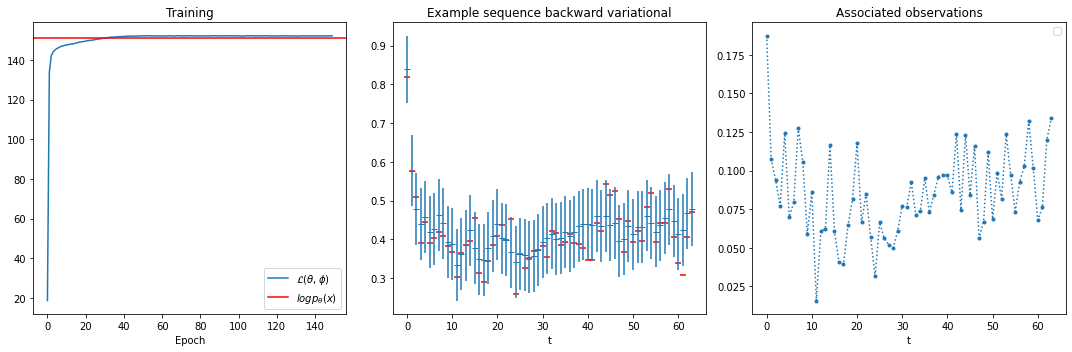

In [9]:
q = hmm.LinearGaussianHMM(state_dim, obs_dim, 'diagonal')

trainer = SVITrainer(p, q, optimizer, num_epochs, batch_size, num_samples)

q_params, avg_elbos = trainer.multi_fit(obs_seqs, p_params, infer_key, num_fits=num_fits)

utils.plot_fit_results_1D(q, q_params, state_seqs, obs_seqs, avg_elbos, avg_evidence_smc)

### Define and fit a nonlinear variational model with filtering and backward updates given by neural networks

End of fit 1/5, final ELBO -542.954
End of fit 2/5, final ELBO 150.061
End of fit 3/5, final ELBO -1225.413
End of fit 4/5, final ELBO 98.159
End of fit 5/5, final ELBO 106.190
Best fit is 2


Backward variational MSE averaged across all sequences: 0.0023104982720687467


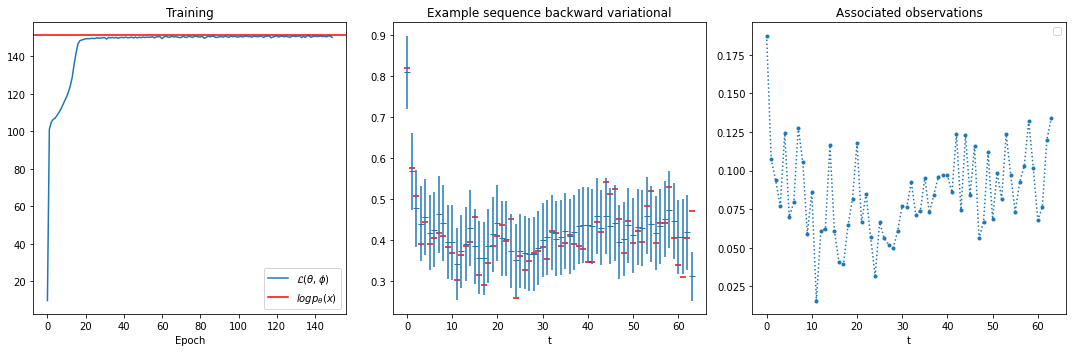

In [10]:
q = hmm.NeuralSmoother(state_dim=state_dim, 
                        obs_dim=obs_dim) # this is a combination of three fully connected neural networks to update the backward and filtering distributions, as well a prior parameter and a shared parameter
trainer = SVITrainer(p, q, optimizer, num_epochs, batch_size, num_samples)

q_params, avg_elbos = trainer.multi_fit(obs_seqs, p_params, infer_key, num_fits=num_fits)

utils.plot_fit_results_1D(q, q_params, state_seqs, obs_seqs, avg_elbos, avg_evidence_smc)